# Optimal Portfolio
This notebook construct 3 different optimal portfolios. The maximum sharpe-ratio portfolio (*simple risk adjusted return*), the maximum calmar-ratio portfolio (*maximum drawdown adjusted return*) and the minimum variance portfolio.

\begin{align}
    \text{Sharpe Ratio}&=\frac{R_{p}-R_{f}}{\sigma_{p}}\\
    \text{Calmar Ratio}&=\frac{R_{p}-R_{f}}{\text{Maximum Drawdown}}
\end{align}
where $R_{p}$ denotes the portfolio's annualized return, $R_{f}$ denotes the risk-free interest rate, $\sigma_{p}$ denotes the standard deviation ($\approx$*risk*) of the portfolio and maximum drawdown is measured as the pct.-change from trough to peak, i.e. peak-value minus trough-value divided by peak-value.




In [1]:
############## Loading relevant packages ##############
import numpy as np
import pandas as pd
import datetime as dt
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# local module
import pftools
import VaR_and_ES as vares
# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

## Loading and cleaning data
In this notebook, data can be fetched using the downloaded CSV-files or using the yahoo database.

In [3]:
# pick which tickers to use in the analysis.
# Make sure names are compatible with yahoo database or file-name
tickers = ['SXR8', 'XACTC25', 'XDJP', 'LCUA' ,'SXRP', 'SXRL', 'XJSE'] # stock and bonds ETFs
tickers = ['SXR8', 'XACTC25', 'XDJP', 'LCUA'] # only stock ETFs

# getting data from a local csv-file
df, rdf, cdf = pftools.df_generator(tickers,'csv','C:/Users/olufk/OneDrive/Documents/GitHub/PortfolioDesign/PortfolioDesign/OptimalPF/Data_Investing_com/')

First observation in dataframe is         28-05-2010
Note that XACTC25    first appears at the 08-02-2019
                     This means theres is missing data from the first 8.7 years, corresponding to approximately 2192 trading days/observations

Note that XDJP       first appears at the 07-03-2013
                     This means theres is missing data from the first 2.77 years, corresponding to approximately 699 trading days/observations

Note that LCUA       first appears at the 11-06-2018
                     This means theres is missing data from the first 8.04 years, corresponding to approximately 2025 trading days/observations



In [4]:
# pick which tickers to use in the analysis.
# Make sure names are compatible with yahoo database or file-name
tickers = ['FORTUM.HE', 'WM','AMD', 'ASML.AS', 'FB', 'SE', '600887.SS', 'SHOP', 'ST5.DE','SNPS','TTD','ZS','NEPA.ST','EW','ACN','NESTE.HE']

# enter time period of interest
start = dt.datetime(2014, 6, 30)
end = dt.datetime(2019, 6, 30)

# getting data from yahoo database
df, rdf, cdf = pftools.df_generator(tickers,'yahoo')

No starttime selected, has therefore chosen default closest to (5 years before today) 2016-09-25
No endtime selected, has therefore chosen default which is the latest trading day as of 2021-09-24

First observation in dataframe is         26-09-2016
Note that SE         first appears at the 20-10-2017
                     This means theres is missing data from the first 1.07 years, corresponding to approximately 268 trading days/observations

Note that ZS         first appears at the 16-03-2018
                     This means theres is missing data from the first 1.47 years, corresponding to approximately 369 trading days/observations



## Describing each tickers
Now that data is loaded, it's time to get an idea of the characteristics of the tickers

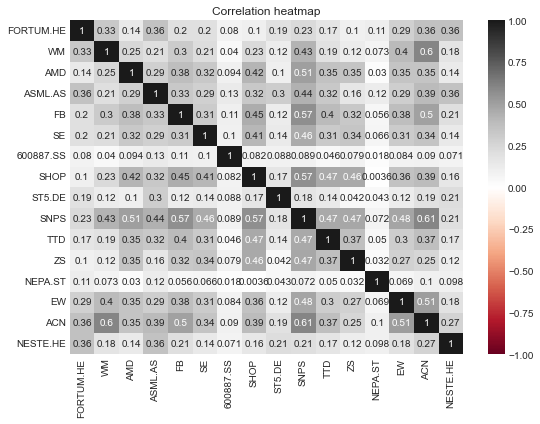

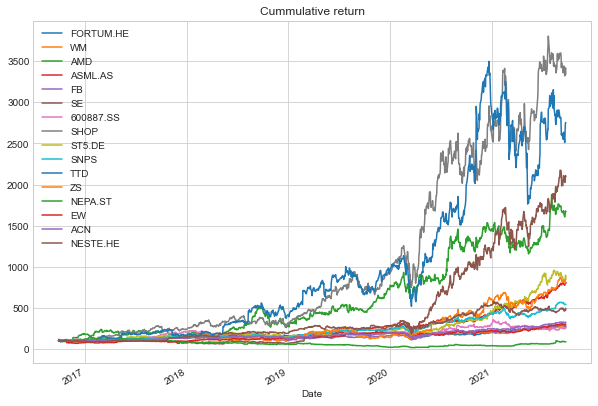

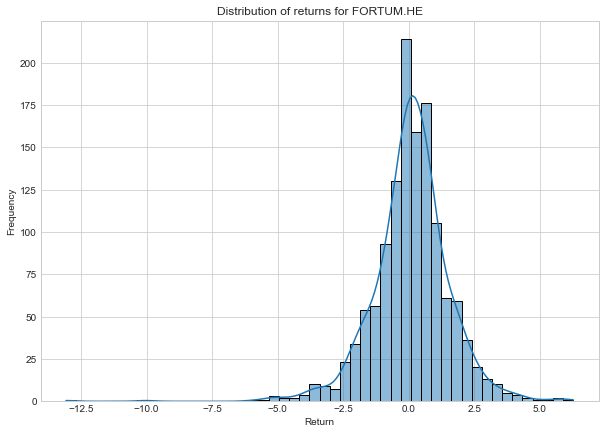

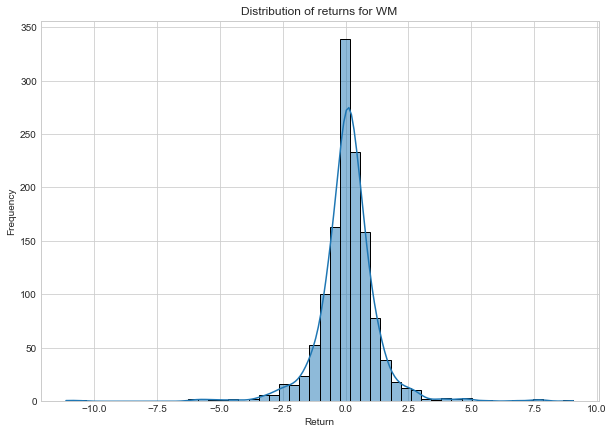

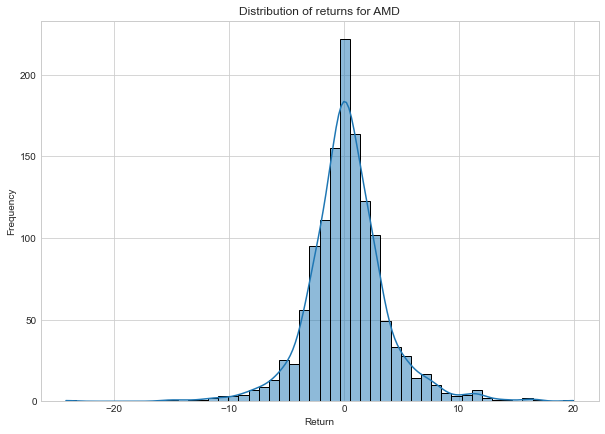

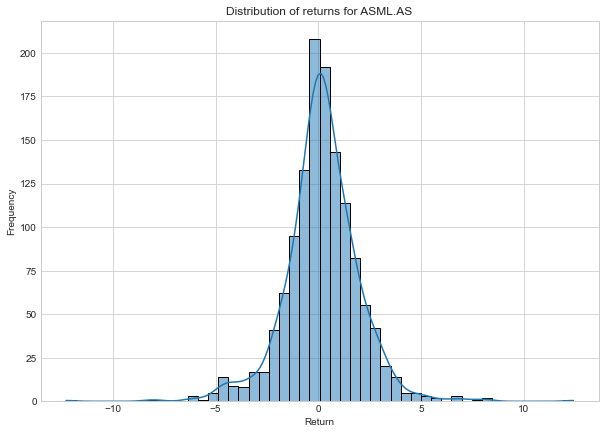

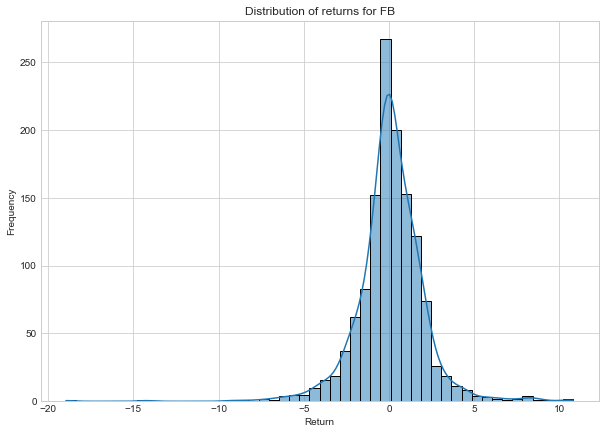

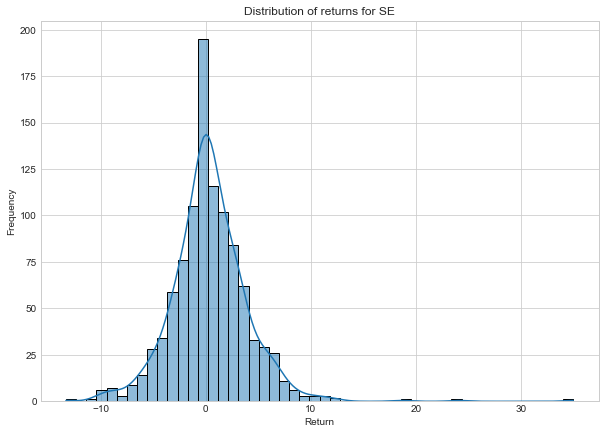

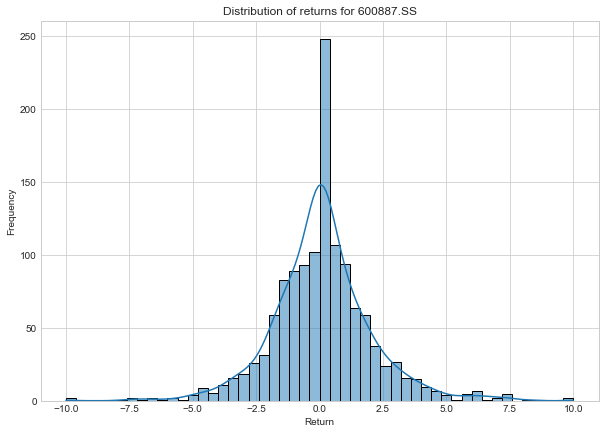

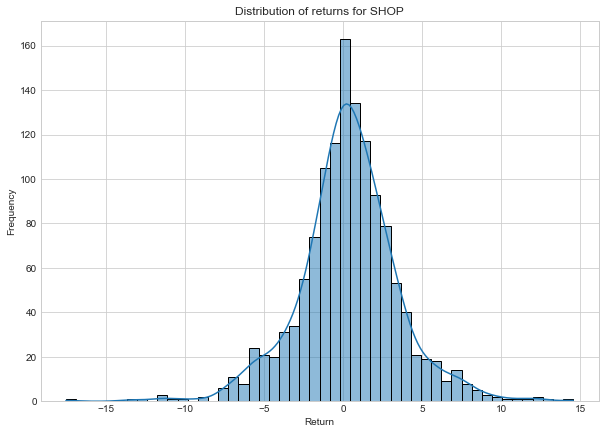

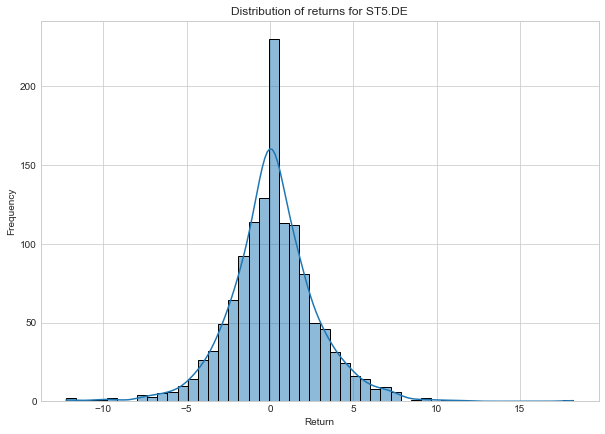

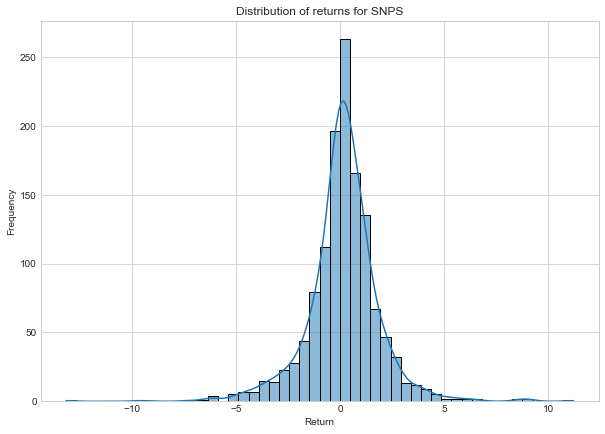

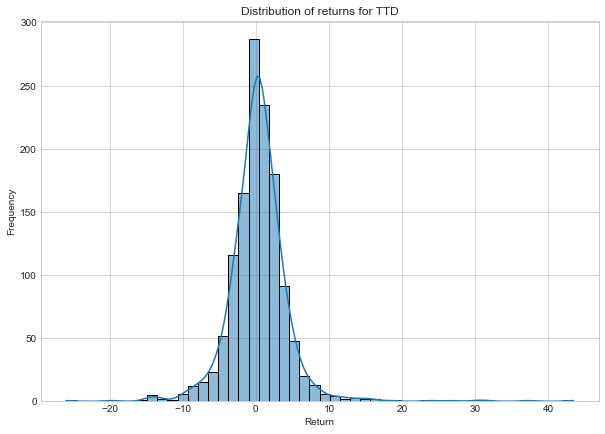

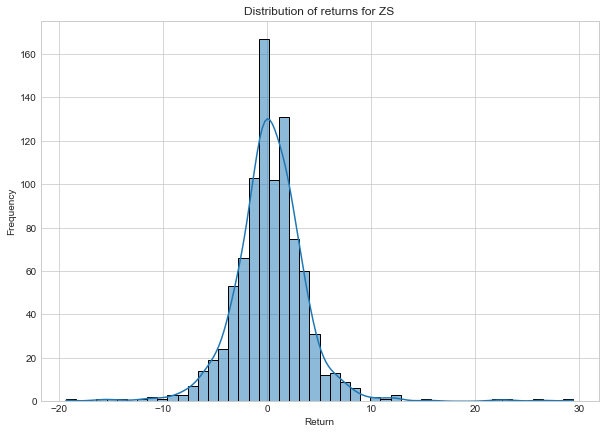

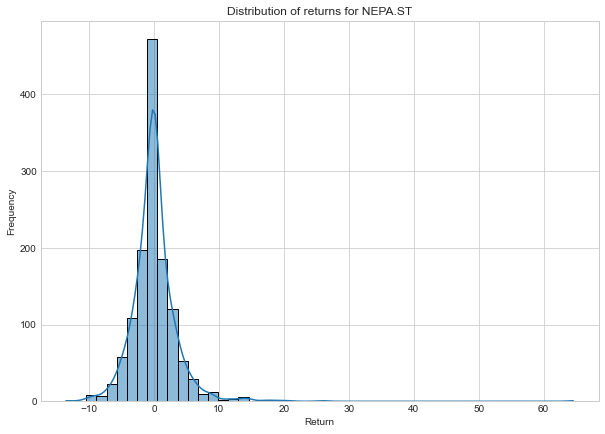

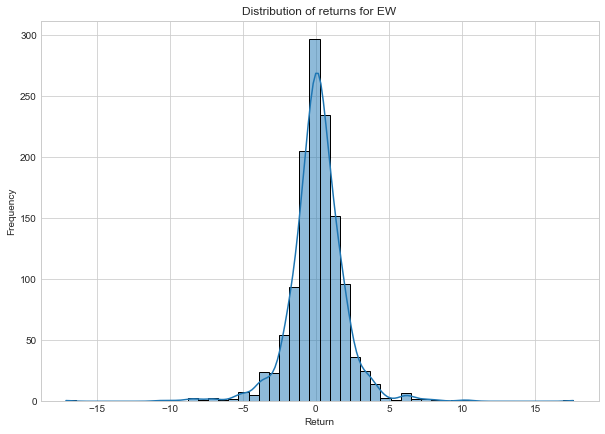

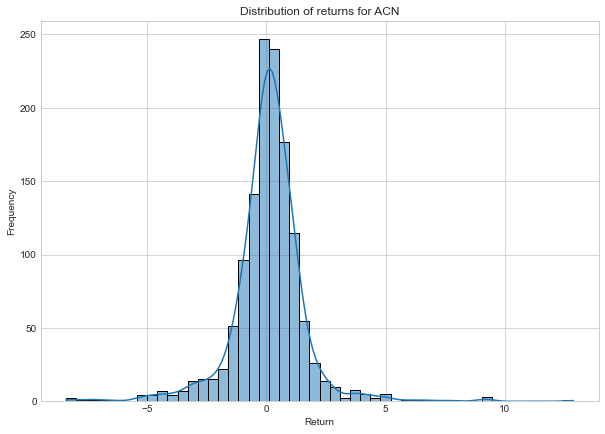

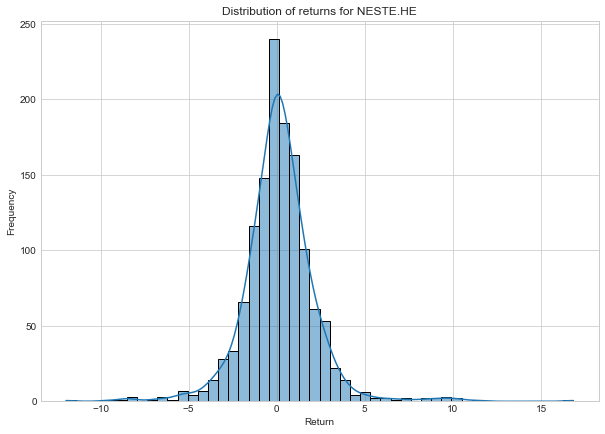

,Annualized return,Volatility,Sharpe ratio,1m max drawdown,Calmar ratio
Ticker,,,,,
FORTUM.HE,22.91,23.59,0.97,40.44,0.57
WM,21.78,20.07,1.09,29.13,0.75
AMD,75.73,55.73,1.36,45.90,1.65
ASML.AS,51.60,28.98,1.78,35.03,1.47
FB,22.71,32.21,0.71,32.53,0.70
SE,116.98,58.08,2.01,27.62,4.24
600887.SS,21.22,32.78,0.65,20.07,1.06
SHOP,101.82,50.50,2.02,39.33,2.59
ST5.DE,53.66,41.95,1.28,48.59,1.10


In [5]:
mu = pftools.desc_ticks(df,rdf,cdf)

In [7]:
omega_hat, alpha_hat, ll = vares.ARCH1_est('TTD',df)

Estimating TTD as a ARCH(1)-model resulted in:
--------------------------------------------------------------------------------------
Omega^hat                       --> 15.1528 with std. errors (0.3675) and t-val 41.2350
alpha^hat                       --> 0.1499 with std. errors (0.0797) and t-val 1.8800
Maximized log-likelihood        --> -5031.472
--------------------------------------------------------------------------------------


Risk measures for TTD at 1 period losses with a 0.05 risk level is
-----------------------------------------
Gauss
-----
VaR                             --> 6.80
ES                              --> 8.53
-----------------------------------------
ARCH(1)
------
VaR (average)                   --> 6.81
ES  (average)                   --> 8.56
-----------------------------------------


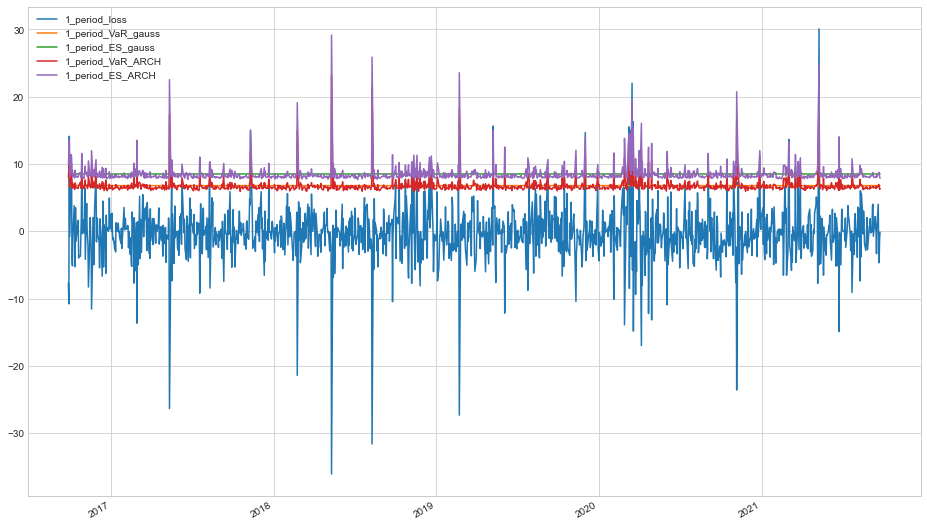

In [8]:
vares_df = vares.VaRES(omega_hat,alpha_hat,df,'TTD',0.05,1,2000)
vares_df.plot(figsize = (16,10));

In [9]:
pftools.ana_optimal_portfolios(df,rdf,mu)

-----------------------------------------------------------------------------------------------

The analytical solution for the minimum variance portfolio (allows for shorting) resulted in:



,weight
Ticker,
FORTUM.HE,17.84
WM,38.53
AMD,-2.02
ASML.AS,7.17
FB,5.83
SE,-3.32
600887.SS,16.24
SHOP,-0.12
ST5.DE,4.60


With portfolio characteristics:



,stats
Annualized return,21.83
Volatility,14.78
Sharpe ratio,1.48
1m max drawdown,27.70
Calmar ratio,0.79


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

The analytical solution for the efficient tangent portfolio (allows for shorting) resulted in:



,weight
Ticker,
FORTUM.HE,4.67
WM,41.72
AMD,7.62
ASML.AS,33.39
FB,-24.51
SE,21.91
600887.SS,8.54
SHOP,23.44
ST5.DE,15.04


With portfolio characteristics:



,stats
Annualized return,87.08
Volatility,29.52
Sharpe ratio,2.95
1m max drawdown,35.21
Calmar ratio,2.47


-----------------------------------------------------------------------------------------------

Cannot analytically solve the maximum calmar ratio portfolio


In [10]:
import warnings
warnings.filterwarnings('ignore') # theres a bug in scipy 1.6 which throws runtime warnings at you. This suppress' it
smvw, stw, scw = pftools.num_optimal_portfolios(df,mu,50,True)

SHORTING IS ALLOWED
-----------------------------------------------------------------------------------------------
Will numerically solve the minimum variance portfolio
Multistart optimizing - prints every time the optimal solution improves 
-----------------------------------------------------------------------------------------------
Attempt 1 of 50 - minvar portfolio - with w0 (initial guess) = [-0.69, 0.18, -0.29, -0.38, 0.44, 0.83, -0.43, 0.18, 0.58, 0.12, -0.32, -0.95, -0.07, -0.54, -0.94, -0.06]
Weights converged at [0.18, 0.39, -0.02, 0.07, 0.06, -0.03, 0.16, -0.0, 0.05, 0.07, -0.02, 0.01, 0.03, 0.03, -0.03, 0.06] with variance = 218.40.

Attempt 2 of 50 - minvar portfolio - with w0 (initial guess) = [-0.07, -0.81, 0.1, 0.78, -0.16, -0.74, 0.97, -0.0, 0.19, 0.19, -0.4, 0.55, 0.88, 0.36, 0.93, 0.54]
Weights converged at [0.18, 0.39, -0.02, 0.07, 0.06, -0.03, 0.16, -0.0, 0.05, 0.07, -0.02, 0.01, 0.03, 0.03, -0.03, 0.06] with variance = 218.40.

Attempt 3 of 50 - minvar portfolio

,weight
Ticker,
FORTUM.HE,17.84
WM,38.53
AMD,-2.02
ASML.AS,7.17
FB,5.83
SE,-3.32
600887.SS,16.24
SHOP,-0.12
ST5.DE,4.60


With portfolio characteristics:



,stats
Annualized return,21.83
Volatility,14.78
Sharpe ratio,1.48
1m max drawdown,27.70
Calmar ratio,0.79


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Will numerically solve the efficient tangent portfolio
Multistart optimizing - prints every time the optimal solution improves 
-----------------------------------------------------------------------------------------------
Attempt 1 of 50 - tangent portfolio - with w0 (initial guess) = [0.48, 0.41, -0.1, -0.77, 0.83, 0.08, 0.89, -0.08, 0.54, 0.64, -0.21, -0.87, 0.49, 0.13, -0.67, 0.86]
Weights converged at [0.05, 0.42, 0.08, 0.33, -0.25, 0.22, 0.09, 0.23, 0.15, -0.23, 0.04, 0.11, -0.05, -0.13, -0.17, 0.12] with Sharpe Ratio = 2.95.

Attempt 3 of 50 - tangent portfolio - with w0 (initial guess) = [0.89, -0.58, -0.54, -0.75, -0.1, 0.01, -0.32, 0.94, -0.97, 0.39, 0.94, -0.32, 0.31, 0.8, 0.49, -0.89]
Weights converged at [0.05, 0.42, 0.08, 0.33, -0.25, 0.22, 0.09, 0.23, 0.15, -0.23, 0.04, 0.11, -0.05

,weight
Ticker,
FORTUM.HE,4.67
WM,41.75
AMD,7.62
ASML.AS,33.40
FB,-24.50
SE,21.91
600887.SS,8.53
SHOP,23.44
ST5.DE,15.03


With portfolio characteristics:



,stats
Annualized return,87.07
Volatility,29.51
Sharpe ratio,2.95
1m max drawdown,35.21
Calmar ratio,2.47


-----------------------------------------------------------------------------------------------
Currently no numerical solution for maximum calmar ratio portfolio with shorting - will therefore be solved for
SHORTING IS NOT ALLOWED
-----------------------------------------------------------------------------------------------
Will numerically solve the calmar portfolio
Multistart optimizing - prints every time the optimal solution improves 
-----------------------------------------------------------------------------------------------
Attempt 1 of 50 - calmar portfolio - with w0 (initial guess) = [0.42, 0.89, 0.29, 0.2, 0.42, 0.03, 0.71, 0.2, 0.57, 0.18, 0.14, 0.1, 0.53, 0.04, 0.88, 0.59]
Weights converged at [0.0, 0.0, 0.0, 0.01, 0.0, 0.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.29, 0.0, 0.0, 0.0, 0.0] with Calmar Ratio = 4.37.

Attempt 2 of 50 - calmar portfolio - with w0 (initial guess) = [0.81, 0.83, 0.45, 0.59, 0.85, 0.45, 0.44, 0.01, 0.91, 0.24, 0.88, 0.33, 0.94, 0.58, 0.66, 0.81]
Weights con

,weight
Ticker,
FORTUM.HE,0.00
WM,0.00
AMD,0.00
ASML.AS,0.00
FB,0.00
SE,75.58
600887.SS,0.00
SHOP,0.00
ST5.DE,0.00


With portfolio characteristics:



,stats
Annualized return,108.76
Volatility,50.59
Sharpe ratio,2.15
1m max drawdown,24.78
Calmar ratio,4.39


-----------------------------------------------------------------------------------------------


In [11]:
mvw, tw, cw = pftools.num_optimal_portfolios(df,mu,20,False)
warnings.filterwarnings('default')

SHORTING IS NOT ALLOWED
-----------------------------------------------------------------------------------------------
Will numerically solve the minimum variance portfolio
Multistart optimizing - prints every time the optimal solution improves 
-----------------------------------------------------------------------------------------------
Attempt 1 of 20 - minvar portfolio - with w0 (initial guess) = [0.4, 0.04, 0.37, 0.62, 0.0, 0.49, 0.58, 0.8, 0.8, 0.96, 0.98, 0.06, 0.35, 0.59, 0.15, 0.24]
Weights converged at [0.18, 0.38, 0.0, 0.06, 0.04, 0.0, 0.17, 0.0, 0.04, 0.02, 0.0, 0.0, 0.03, 0.01, 0.0, 0.06] with variance = 225.01.

Attempt 3 of 20 - minvar portfolio - with w0 (initial guess) = [0.51, 0.16, 0.62, 0.38, 0.76, 0.43, 0.11, 0.53, 0.38, 0.35, 0.12, 0.41, 0.78, 0.4, 0.33, 0.1]
Weights converged at [0.18, 0.38, 0.0, 0.06, 0.04, 0.0, 0.17, 0.0, 0.04, 0.02, 0.0, 0.0, 0.03, 0.01, 0.0, 0.06] with variance = 225.01.

Attempt 16 of 20 - minvar portfolio - with w0 (initial guess) = [0.11

,weight
Ticker,
FORTUM.HE,17.70
WM,38.50
AMD,0.00
ASML.AS,5.66
FB,4.22
SE,0.00
600887.SS,16.51
SHOP,0.00
ST5.DE,4.43


With portfolio characteristics:



,stats
Annualized return,25.79
Volatility,15.00
Sharpe ratio,1.72
1m max drawdown,28.26
Calmar ratio,0.91


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Will numerically solve the efficient tangent portfolio
Multistart optimizing - prints every time the optimal solution improves 
-----------------------------------------------------------------------------------------------
Attempt 1 of 20 - tangent portfolio - with w0 (initial guess) = [0.44, 0.91, 0.59, 0.86, 0.5, 0.66, 0.19, 0.62, 0.02, 0.8, 0.14, 0.17, 0.86, 0.41, 0.35, 0.95]
Weights converged at [0.01, 0.12, 0.02, 0.21, 0.0, 0.16, 0.07, 0.15, 0.13, 0.0, 0.01, 0.05, 0.0, 0.0, 0.0, 0.08] with Sharpe Ratio = 2.72.

Attempt 2 of 20 - tangent portfolio - with w0 (initial guess) = [0.97, 0.51, 0.52, 0.64, 0.68, 0.2, 0.21, 0.39, 0.19, 0.3, 0.59, 0.04, 0.1, 0.16, 0.23, 0.28]
Weights converged at [0.01, 0.12, 0.02, 0.21, 0.0, 0.16, 0.07, 0.15, 0.13, 0.0, 0.01, 0.05, 0.0, 0.0, 0.0, 0.08] with Sharpe Ra

,weight
Ticker,
FORTUM.HE,0.56
WM,11.84
AMD,2.18
ASML.AS,20.56
FB,0.00
SE,15.67
600887.SS,6.63
SHOP,15.48
ST5.DE,13.21


With portfolio characteristics:



,stats
Annualized return,65.31
Volatility,24.02
Sharpe ratio,2.72
1m max drawdown,33.88
Calmar ratio,1.93


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Will numerically solve the calmar portfolio
Multistart optimizing - prints every time the optimal solution improves 
-----------------------------------------------------------------------------------------------
Attempt 1 of 20 - calmar portfolio - with w0 (initial guess) = [0.57, 0.66, 0.13, 0.44, 0.8, 0.37, 0.63, 0.15, 0.34, 0.62, 0.21, 0.6, 0.22, 0.01, 0.76, 0.73]
Weights converged at [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] with Calmar Ratio = 4.24.

Attempt 2 of 20 - calmar portfolio - with w0 (initial guess) = [0.87, 0.17, 0.09, 0.56, 0.43, 0.96, 0.03, 0.12, 0.25, 0.69, 0.64, 0.78, 0.69, 0.65, 0.45, 0.88]
Weights converged at [0.0, 0.0, 0.0, 0.0, 0.0, 0.76, 0.0, 0.0, 0.0, 0.0, 0.0, 0.24, 0.0, 0.0, 0.0, 0.0] with Calmar Ratio = 4.39.

-----------------

,weight
Ticker,
FORTUM.HE,0.00
WM,0.00
AMD,0.00
ASML.AS,0.00
FB,0.00
SE,75.58
600887.SS,0.00
SHOP,0.00
ST5.DE,0.00


With portfolio characteristics:



,stats
Annualized return,108.76
Volatility,50.59
Sharpe ratio,2.15
1m max drawdown,24.78
Calmar ratio,4.39


-----------------------------------------------------------------------------------------------


Simulating 1000 timeseries for each type of portfolio where shorting is allowed
--------------------------------------------------------------------------------

Simulates the minimum variance portfolio 1000 times over 63 days


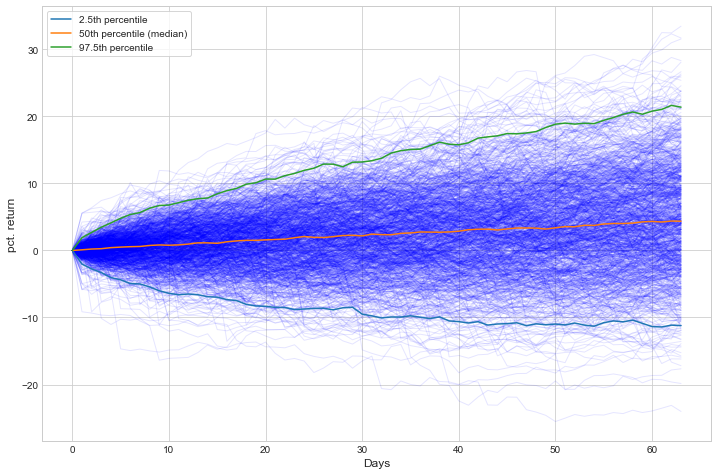

----------------------------------------------------------------------------------------------------

Simulates the efficient tangent portfolio 1000 times over 63 days


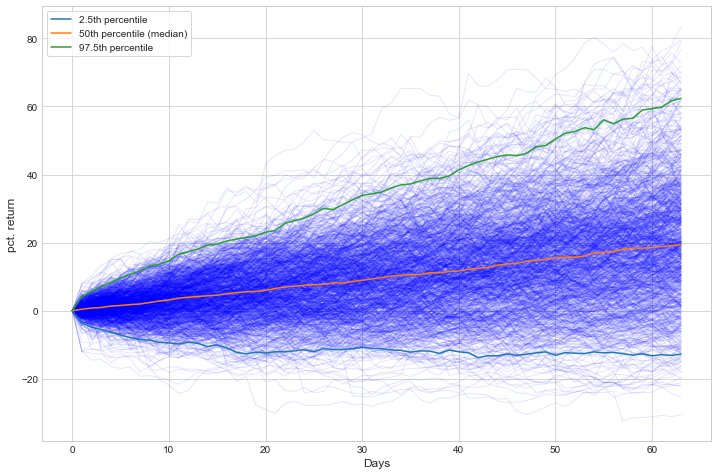

----------------------------------------------------------------------------------------------------
Simulates the optimal calmar ratio portfolio (shorting is not allowed) 1000 times over 63 days


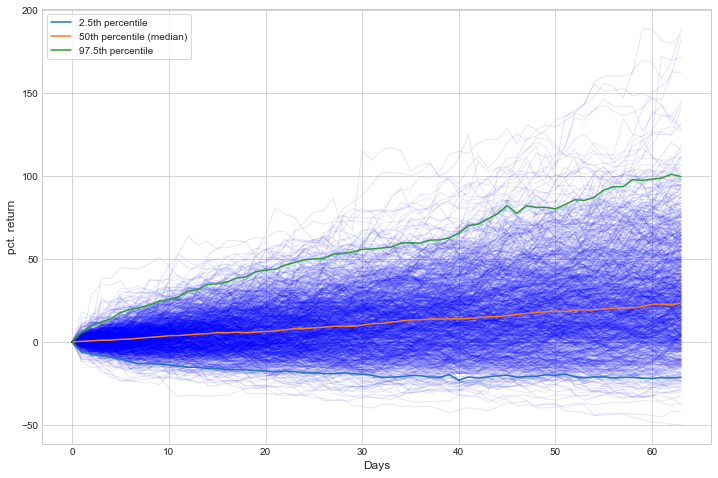

In [12]:
pftools.simulated_portfolios(smvw, stw, scw, rdf, N = 1000, t = 63, shorting = True)

Simulating 1000 timeseries for each type of portfolio where shorting is NOT allowed
--------------------------------------------------------------------------------

Simulates the minimum variance portfolio 1000 times over 63 days


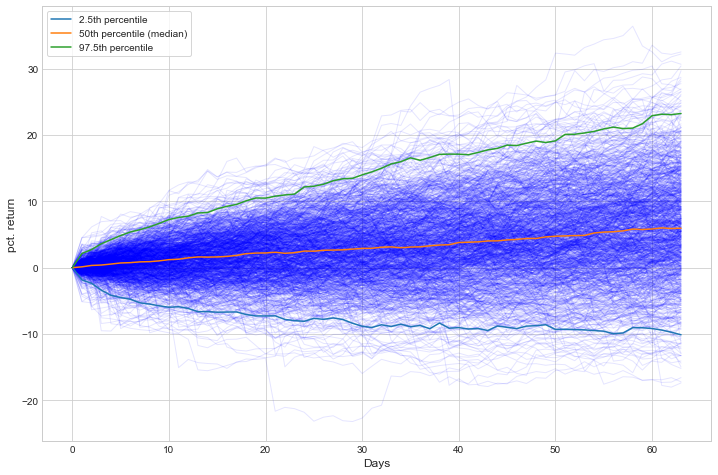

----------------------------------------------------------------------------------------------------

Simulates the efficient tangent portfolio 1000 times over 63 days


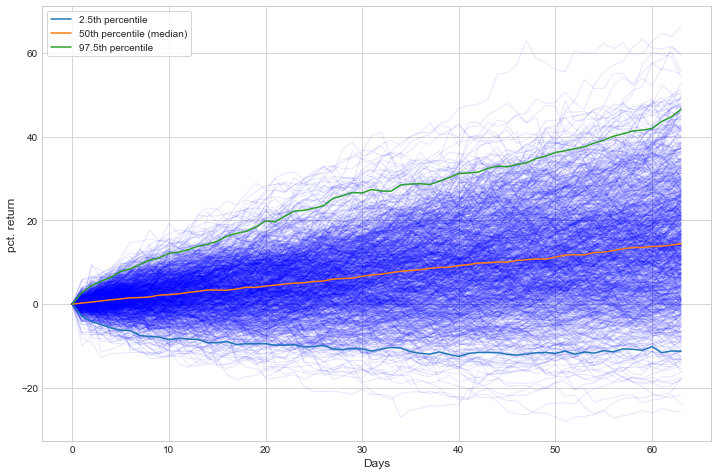

----------------------------------------------------------------------------------------------------
Simulates the optimal calmar ratio portfolio (shorting is not allowed) 1000 times over 63 days


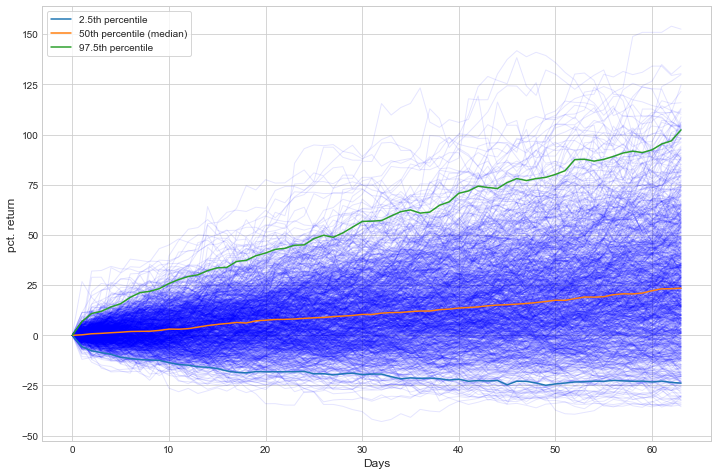

In [13]:
pftools.simulated_portfolios(mvw, tw, cw, rdf, N = 1000, t = 63)

In [34]:
array1 = np.array([-0.93, -0.18, 0.11, -0.61])
array2 = np.array([-0.93, -0.18, 0.11, -0.61])
array3 = np.array([-0.93, -0.18, 0.11, -0.61])
array4 = np.array([-0.93, -0.18, 0.11, -0.61])
arrays = np.array([array1,array2,array3,array4])
k = int(5/2)
arrays[:-k]
arrays[k:]
# if np.all(arrays[:-1] == arrays[1:]):
#     print('Identical')
# else:
#     print('Not identical')

array([[-0.93, -0.18,  0.11, -0.61],
       [-0.93, -0.18,  0.11, -0.61]])